In [ ]:
! pip install scikit-fuzzy

**Fuzzy Logic: Grading Student Performance**

**Author: Satyajit Ghana**

---

# Fuzzy Logic Grading System

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import skfuzzy as fuzz

from skfuzzy import control as ctrl
from random import choice
from collections import defaultdict, namedtuple
from pprint import pprint

from IPython.display import display

sns.set()

## Project Evaluation Attributes

In [33]:
project_features = dict(
    documentation=['excellent', 'good', 'satisfying', 'moderate', 'limited', 'bad'],
    presentation=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'],
    security_auth=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'],
    functionality=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'],
    design_ui=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'],
    modularity=['very_high', 'high', 'medium', 'low', 'very_low', 'nil']
)

## Dataset

In [49]:
MAX_STUDENTS = 50
MAX_EVALUATORS = 3

In [57]:
dataset = {}

for evaluator in range(MAX_EVALUATORS):
    df = pd.DataFrame(data={
                        feat: [choice(attrs) for _ in range(MAX_STUDENTS)]
                        for feat, attrs in project_features.items()
                    }, index=[f'student_{num+1:02}' for num in range(MAX_STUDENTS)], dtype ="category")
    
    dataset[f'evaluator_{evaluator:02}'] = df.copy()

In [58]:
dataset.keys()

dict_keys(['evaluator_00', 'evaluator_01', 'evaluator_02'])

In [68]:
for evaluator, data in dataset.items():
    print(f"Data for {evaluator}")
    display(data.info())
    print()

Data for evaluator_00
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, student_01 to student_50
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   documentation  50 non-null     category
 1   presentation   50 non-null     category
 2   security_auth  50 non-null     category
 3   functionality  50 non-null     category
 4   design_ui      50 non-null     category
 5   modularity     50 non-null     category
dtypes: category(6)
memory usage: 1.9+ KB


None


Data for evaluator_01
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, student_01 to student_50
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   documentation  50 non-null     category
 1   presentation   50 non-null     category
 2   security_auth  50 non-null     category
 3   functionality  50 non-null     category
 4   design_ui      50 non-null     category
 5   modularity     50 non-null     category
dtypes: category(6)
memory usage: 1.9+ KB


None


Data for evaluator_02
<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, student_01 to student_50
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   documentation  50 non-null     category
 1   presentation   50 non-null     category
 2   security_auth  50 non-null     category
 3   functionality  50 non-null     category
 4   design_ui      50 non-null     category
 5   modularity     50 non-null     category
dtypes: category(6)
memory usage: 1.9+ KB


None

In [67]:
for evaluator, data in dataset.items():
    print(f"Data for {evaluator}")
    display(data.head())
    print()

Data for evaluator_00


,documentation,presentation,security_auth,functionality,design_ui,modularity
student_01,bad,very_good,bad,bad,fair,high
student_02,satisfying,average,bad,fair,good,very_low
student_03,excellent,bad,excellent,good,good,medium
student_04,satisfying,good,average,very_good,bad,medium
student_05,moderate,average,bad,bad,bad,medium



Data for evaluator_01


,documentation,presentation,security_auth,functionality,design_ui,modularity
student_01,limited,fair,excellent,average,very_good,low
student_02,limited,excellent,bad,good,very_good,very_low
student_03,good,average,fair,average,good,very_low
student_04,good,fair,very_good,fair,good,medium
student_05,moderate,average,bad,average,good,low



Data for evaluator_02


,documentation,presentation,security_auth,functionality,design_ui,modularity
student_01,good,excellent,very_good,excellent,very_good,high
student_02,bad,fair,bad,bad,good,high
student_03,limited,excellent,fair,good,bad,high
student_04,bad,excellent,average,fair,excellent,nil
student_05,satisfying,average,very_good,excellent,average,low


## Fuzzy Logic

In [3]:
def get_tri_vals(vals, x_min=1, x_max=6):
    start_val = vals[0]
    end_val = vals[-1]
    max_point, max_x = max(vals), vals.index(max(vals))
    max_x += 1

    # x = (y - y1)*(x2 - x1)/(y2 - y1) + x1

    # (x1   , y1       ), (x2    , y2      )
    # (x_min, start_val), (max_x, max_point)
    line_one_fun = lambda y: (y - start_val) * (max_x - x_min) / (max_point - start_val) + x_min

    # (x1   , y1       ), (x2   , y2      )
    # (max_x, max_point), (x_max, end_val)
    line_two_fun = lambda y: (y - max_point) * (x_max - max_x) / (end_val - max_point) + max_x

    if max_point == start_val:
        x_left = x_min
    else:
        x_left = line_one_fun(0)
    
    if end_val == max_point:
        x_right = x_max
    else:
        x_right = line_two_fun(0)

    return [x_left, max_x, x_right]    


In [4]:
get_tri_vals([1, 0.8, 0.6, 0.4, 0.2, 0])

[1, 1, 6.0]

In [5]:
def get_fuzzy_set_grid(val_min, val_max, grid_size=6):

    init_vals = np.linspace(val_max, val_min, grid_size)
    grid_vals = np.array([init_vals])
    
    for val in np.linspace(val_max, val_min, grid_size)[1:]:
        init_vals = init_vals[:-1]
        init_vals = np.concatenate((np.array([val]), init_vals))
        
        grid_vals = np.append(grid_vals, np.array([init_vals.copy()]), axis=0)

    return grid_vals


In [6]:
get_fuzzy_set_grid(0, 1, grid_size=6)

array([[1. , 0.8, 0.6, 0.4, 0.2, 0. ],
       [0.8, 1. , 0.8, 0.6, 0.4, 0.2],
       [0.6, 0.8, 1. , 0.8, 0.6, 0.4],
       [0.4, 0.6, 0.8, 1. , 0.8, 0.6],
       [0.2, 0.4, 0.6, 0.8, 1. , 0.8],
       [0. , 0.2, 0.4, 0.6, 0.8, 1. ]])

In [74]:
FuzzySet = namedtuple('FuzzySet', field_names=['attrs', 'set'])

In [76]:
fuzzy_sets = defaultdict(dict)
for proj_feat, proj_attrs in project_features.items():
    num_terms = len(proj_attrs)

    fuzzy_grid = get_fuzzy_set_grid(0, 1, grid_size=num_terms)

    # create the fuzzy set
    proj_set = ctrl.Antecedent(np.arange(1, num_terms + 1, 1), proj_feat)

    fuzzy_sets[proj_feat] = FuzzySet(proj_attrs, proj_set)

    # assign the membership function
    for idx, attr in enumerate(fuzzy_sets[proj_feat].attrs):
        fuzzy_sets[proj_feat].set[attr] = fuzz.trimf(fuzzy_sets[proj_feat].set.universe, get_tri_vals(list(fuzzy_grid[idx, :])))

In [108]:
fuzzy_sets

defaultdict(dict,
            {'design_ui': FuzzySet(attrs=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'], set=Antecedent: design_ui),
             'documentation': FuzzySet(attrs=['excellent', 'good', 'satisfying', 'moderate', 'limited', 'bad'], set=Antecedent: documentation),
             'functionality': FuzzySet(attrs=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'], set=Antecedent: functionality),
             'modularity': FuzzySet(attrs=['very_high', 'high', 'medium', 'low', 'very_low', 'nil'], set=Antecedent: modularity),
             'presentation': FuzzySet(attrs=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'], set=Antecedent: presentation),
             'security_auth': FuzzySet(attrs=['excellent', 'very_good', 'good', 'average', 'fair', 'bad'], set=Antecedent: security_auth)})

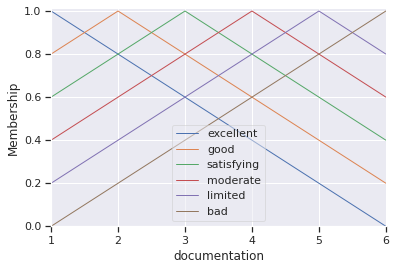

In [84]:
fuzzy_sets['documentation'].set.view()

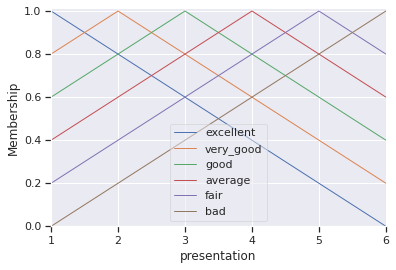

In [85]:
fuzzy_sets['presentation'].set.view()

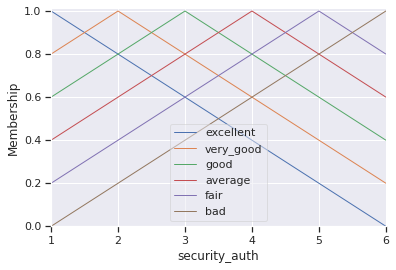

In [86]:
fuzzy_sets['security_auth'].set.view()

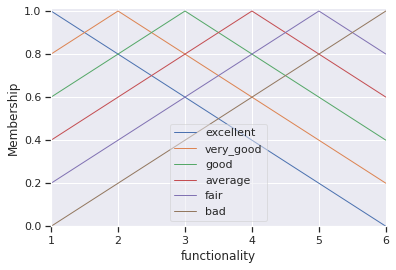

In [87]:
fuzzy_sets['functionality'].set.view()

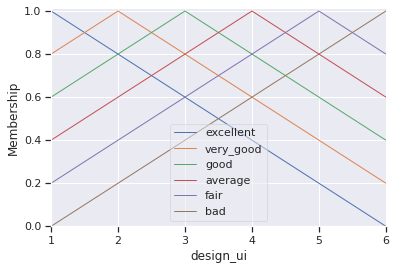

In [88]:
fuzzy_sets['design_ui'].set.view()

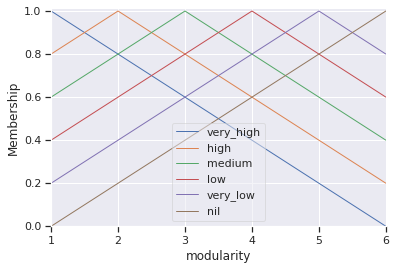

In [89]:
fuzzy_sets['modularity'].set.view()

In [94]:
ideal_performance_sets = {
    'documentation': fuzzy_sets['documentation'].set['excellent'].mf,
    'presentation': fuzzy_sets['presentation'].set['excellent'].mf,
    'security_auth': fuzzy_sets['security_auth'].set['excellent'].mf,
    'functionality': fuzzy_sets['functionality'].set['excellent'].mf,
    'modularity': fuzzy_sets['modularity'].set['very_high'].mf,
    'design_ui': fuzzy_sets['design_ui'].set['excellent'].mf
}

In [106]:
pprint(ideal_performance_sets)

{'design_ui': array([1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 'documentation': array([1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 'functionality': array([1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 'modularity': array([1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 'presentation': array([1. , 0.8, 0.6, 0.4, 0.2, 0. ]),
 'security_auth': array([1. , 0.8, 0.6, 0.4, 0.2, 0. ])}


## Evaluating Student Performance

In [110]:
dataset.keys()

dict_keys(['evaluator_00', 'evaluator_01', 'evaluator_02'])

Let's see how it works out for one student

In [170]:
def create_student_df(student_idx, dataset):
    student_remarks = pd.DataFrame([dataset[evaluator].iloc[student_idx] for evaluator in dataset.keys()]).T
    student_remarks.columns=dataset.keys()

    return student_remarks

In [199]:
def evaluate_student(student_remarks, debug=False):
    performance_metric = {'total_dist': 0}
    for idx, evaluation in student_remarks.iterrows():
        if debug:
            print(evaluation.name)
        overall_opinion = np.array(list(map(lambda x: fuzzy_sets[evaluation.name].set[x].mf, evaluation.values))).min(axis=0)
        distance_from_ideal = np.abs(ideal_performance_sets[evaluation.name] - overall_opinion).sum()
        performance_metric[evaluation.name] = distance_from_ideal
        performance_metric['total_dist'] += distance_from_ideal

        if debug:
            print('overall opinion: ', overall_opinion)
            print('distance from ideal: ', distance_from_ideal)
            print()

    return performance_metric

In [200]:
student_evaluation = pd.DataFrame(data={eval_param: [] for eval_param in project_features.keys()})
student_evaluation['total_dist'] = []
for student_idx in range(0, MAX_STUDENTS):
    student_remarks = create_student_df(student_idx, dataset)
    display(student_remarks)

    print("\nEvaluation\n")
    
    evaluation = evaluate_student(student_remarks, debug=True)

    print(evaluation)
    print()

    student_evaluation.loc[f'student_{student_idx:02}'] = evaluation

    break # do only for one student

display(student_evaluation)

,evaluator_00,evaluator_01,evaluator_02
documentation,bad,limited,good
presentation,very_good,fair,excellent
security_auth,bad,excellent,very_good
functionality,bad,average,excellent
design_ui,fair,very_good,very_good
modularity,high,low,high



Evaluation

documentation
overall opinion:  [0.  0.2 0.4 0.6 0.4 0.2]
distance from ideal:  2.4000000000000004

presentation
overall opinion:  [0.2 0.4 0.6 0.4 0.2 0. ]
distance from ideal:  1.2000000000000002

security_auth
overall opinion:  [0.  0.2 0.4 0.4 0.2 0. ]
distance from ideal:  1.8

functionality
overall opinion:  [0.  0.2 0.4 0.4 0.2 0. ]
distance from ideal:  1.8

design_ui
overall opinion:  [0.2 0.4 0.6 0.6 0.4 0.2]
distance from ideal:  1.8

modularity
overall opinion:  [0.4 0.6 0.8 0.6 0.4 0.2]
distance from ideal:  1.5999999999999999

{'total_dist': 10.6, 'documentation': 2.4000000000000004, 'presentation': 1.2000000000000002, 'security_auth': 1.8, 'functionality': 1.8, 'design_ui': 1.8, 'modularity': 1.5999999999999999}



,documentation,presentation,security_auth,functionality,design_ui,modularity,total_dist
student_00,2.4,1.2,1.8,1.8,1.8,1.6,10.6


Now apply the same logic over all the student

In [201]:
student_evaluation = pd.DataFrame(data={eval_param: [] for eval_param in project_features.keys()})
student_evaluation['total_dist'] = []
for student_idx in range(0, MAX_STUDENTS):
    student_remarks = create_student_df(student_idx, dataset)
    evaluation = evaluate_student(student_remarks)
    student_evaluation.loc[f'student_{student_idx:02}'] = evaluation

In [231]:
student_evaluation.describe().T

,count,mean,std,min,25%,50%,75%,max
documentation,50.0,1.812,0.911970,0.0,1.20,1.8,2.40,3.6
presentation,50.0,1.752,0.874640,0.2,1.20,1.8,2.40,3.4
security_auth,50.0,1.936,0.794306,0.2,1.30,1.8,2.40,3.6
functionality,50.0,1.868,0.781009,0.2,1.35,1.8,2.40,3.4
design_ui,50.0,1.728,0.749160,0.2,1.20,1.8,2.40,3.4
modularity,50.0,1.912,0.919769,0.2,1.20,1.8,2.40,3.4
total_dist,50.0,11.008,2.179294,3.2,10.10,11.1,12.35,15.6


Display the ranking of students

In [203]:
student_evaluation.sort_values('total_dist', ascending=True)

,documentation,presentation,security_auth,functionality,design_ui,modularity,total_dist
student_41,1.2,0.2,0.2,0.2,1.2,0.2,3.2
student_49,0.8,2.2,1.2,2.4,0.2,0.2,7.0
student_27,1.8,0.2,1.8,0.8,1.8,1.2,7.6
student_33,1.2,1.2,1.2,2.4,0.8,0.8,7.6
student_08,1.2,1.2,1.2,1.8,1.2,1.2,7.8
student_44,1.2,2.4,1.8,0.4,0.8,1.8,8.4
student_16,2.4,1.2,1.8,1.8,0.4,1.2,8.8
student_14,2.4,1.8,2.8,0.8,0.8,0.4,9.0
student_26,0.4,0.4,2.4,1.8,2.4,1.8,9.2
student_17,0.8,1.2,1.6,2.8,1.2,1.8,9.4


In [208]:
[fuzzy_sets['documentation'].set['good'].mf,
 fuzzy_sets['presentation'].set['very_good'].mf,
 fuzzy_sets['security_auth'].set['very_good'].mf,
 fuzzy_sets['functionality'].set['very_good'].mf,
 fuzzy_sets['design_ui'].set['very_good'].mf,
 fuzzy_sets['modularity'].set['high'].mf]

[array([0.8, 1. , 0.8, 0.6, 0.4, 0.2]),
 array([0.8, 1. , 0.8, 0.6, 0.4, 0.2]),
 array([0.8, 1. , 0.8, 0.6, 0.4, 0.2]),
 array([0.8, 1. , 0.8, 0.6, 0.4, 0.2]),
 array([0.8, 1. , 0.8, 0.6, 0.4, 0.2]),
 array([0.8, 1. , 0.8, 0.6, 0.4, 0.2])]

In [213]:
grading_dists = {
    'Ex': 6 * np.abs(fuzzy_grid[0, :] - fuzzy_grid[0, :]).sum(),
    'A+': 6 * np.abs(fuzzy_grid[0, :] - fuzzy_grid[1, :]).sum(),
    'A':  6 * np.abs(fuzzy_grid[0, :] - fuzzy_grid[2, :]).sum(),
    'B+': 6 * np.abs(fuzzy_grid[0, :] - fuzzy_grid[3, :]).sum(),
    'B':  6 * np.abs(fuzzy_grid[0, :] - fuzzy_grid[4, :]).sum(),
    'C':  6 * np.abs(fuzzy_grid[0, :] - fuzzy_grid[5, :]).sum()
}

In [216]:
sorted_grading_dists = sorted(grading_dists.items(), key=lambda x: x[1])
sorted_grading_dists

[('Ex', 0.0),
 ('A+', 7.199999999999999),
 ('A', 12.0),
 ('B+', 16.8),
 ('B', 19.200000000000003),
 ('C', 21.6)]

In [222]:
student_evaluation['grade'] = pd.cut(student_evaluation['total_dist'], bins=[gdist[1] for gdist in sorted_grading_dists] + [np.inf], labels=[gdist[0] for gdist in sorted_grading_dists])

display grades of students

In [228]:
student_evaluation[['total_dist', 'grade']]

,total_dist,grade
student_00,10.6,A+
student_01,13.4,A
student_02,11.0,A+
student_03,11.6,A+
student_04,14.2,A
student_05,9.8,A+
student_06,10.4,A+
student_07,12.2,A
student_08,7.8,A+
student_09,12.8,A


Display sorted Grades

In [232]:
student_evaluation.sort_values('total_dist', ascending=True)[['total_dist', 'grade']]

,total_dist,grade
student_41,3.2,Ex
student_49,7.0,Ex
student_27,7.6,A+
student_33,7.6,A+
student_08,7.8,A+
student_44,8.4,A+
student_16,8.8,A+
student_14,9.0,A+
student_26,9.2,A+
student_17,9.4,A+


## Convert this notebook to pdf

In [233]:
%%capture
! apt update
! apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [234]:
import subprocess
import shlex

Convert to pdf

In [235]:
s = subprocess.Popen(shlex.split(
    f'jupyter nbconvert /content/fuzzy-logic-grading-system.ipynb --to pdf'
    ), shell = False, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
s.wait()
s.stdout.read()

b''